# Домашнее задание 2

Самохвалов Михаил

Группа MADE-DS-32

sam2051@yandex.ru

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.


In [92]:
import gym
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from collections import namedtuple
from tqdm.notebook import tqdm
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Часть первая: крестики-нолики при помощи Q-обучения

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

## 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [5]:
# Action - i,j клетки
# State: 
#     1 - empty
#     0 - O
#     2 - X
# Turn: 1 -> X, -1 -> O

In [85]:
class Strategy:
    
    def __init__(self):
        pass
    
    def get_action(self):
        pass
    
    def update(self):
        pass
    
    def reset_state(self):
        pass
    
    
class RandomStrategy(Strategy):
    
    def __init__(self):
        pass
    
    def get_action(self, state, empty_spaces):
        return np.random.randint(len(empty_spaces))
    
    def update(self, new_state, reward):
        pass
    
    
class QStrategy(Strategy):
    def __init__(self, state, alpha=0.05, gamma=1.0, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.Q = {} # defaultdict(lambda: np.zeros(len(state)))
        self.state = None
        self.act_idx = None
        
    def get_action(self, state, empty_spaces):
        """Return action index"""
        if state in self.Q and np.random.random() > self.epsilon:
#             print('  first')
            return np.argmax(self.Q[state])
        else:
#             print('  second')
            if state not in self.Q:
                self.Q[state] = np.zeros(len(empty_spaces))
            return np.random.randint(len(empty_spaces))
            
    
    def update(self, new_state, reward):
#         print('new_state',new_state)
#         print('  prev state',self.state)
#         print('  prev_action', self.act_idx)
#         print('    ',self.Q)
        if self.state:
            if new_state in self.Q:
                tmp = self.gamma * np.max(self.Q[new_state])
            else:
                tmp = 0
            
#             print('  gamma', tmp)
            self.Q[self.state][self.act_idx] = self.Q[self.state][self.act_idx] + \
                self.alpha * (reward + tmp - self.Q[self.state][self.act_idx])
#             print('  NEW VALUE', self.Q[self.state][self.act_idx])
    
    def reset_state(self):
        self.state = None
        self.act_idx = None

In [86]:
def Q_testing_episode(env, agent1, agent2, random_agent):
    env.reset()
    state, empty_spaces, turn = env.getState()
    reward = 0
    done = False
    
    while not done:
        if turn == 1:
            if random_agent == 1 and state in agent1.Q:
                action_idx = np.argmax(agent1.Q[state])
            else:
                action_idx = np.random.randint(len(empty_spaces))
        elif turn == -1:
            if random_agent == 0 and state in agent2.Q:
                action_idx = np.argmax(agent2.Q[state])
            else:
                action_idx = np.random.randint(len(empty_spaces))
        observation, reward, done, _ = env.step(empty_spaces[action_idx])
        state, empty_spaces, turn = observation
#     print('   ', reward)
    return reward


def Q_testing(env, agent1, agent2, games=500):
    reward_X = 0
    reward_O = 0
    for i in range(games):
        reward_X += Q_testing_episode(env, agent1, agent2, random_agent=1)
    for i in range(games):
        reward_O += Q_testing_episode(env, agent1, agent2, random_agent=0)
#     print(reward_X)
#     print(reward_O)
    return reward_X / games, -reward_O / games

def Q_learning_episode(env, agent1, agent2, train=True):
    env.reset()
    state, empty_spaces, turn = env.getState()
    reward = 0
    done = False
    
    agent1.reset_state()
    agent2.reset_state()

    while not done:
        if turn == 1:
#             print('*'*40)
#             print('TURN X')
#             print('state',state)
            action_idx = agent1.get_action(state, empty_spaces)
#             print('action',action_idx)
#             print('empty',empty_spaces)
            observation, reward, done, _ = env.step(empty_spaces[action_idx])
            new_state = observation[0]
            agent2.update(new_state, -reward)
            if reward == 1:
                agent1.Q[state][action_idx] = reward
            agent1.state = state
            agent1.act_idx = action_idx
            
        elif turn == -1:
#             print('*'*40)
#             print('TURN O')
#             print('state',state)
            action_idx = agent2.get_action(state, empty_spaces)
#             print('action',action_idx)
#             print('empty',empty_spaces)
            observation, reward, done, _ = env.step(empty_spaces[action_idx])
            new_state = observation[0]
            agent1.update(new_state, reward)
            if reward == -1:
                agent2.Q[state][action_idx] = -reward
            agent2.state = state
            agent2.act_idx = action_idx
        state, empty_spaces, turn = observation
    return reward


def Q_training(env, agent1, agent2, episodes=10000, eval_step=1000):
    history_X = []
    history_O = []
    steps = []
    
#     random_agent = RandomStrategy()
    for i in tqdm(range(episodes)):
        Q_learning_episode(env, agent1, agent2)
            
        if i % eval_step == 0:
            res1, res2 = Q_testing(env, agent1, agent2)
            history_X.append(res1)
            history_O.append(res2)
            steps.append(i)
            
    return steps, history_X, history_O
            


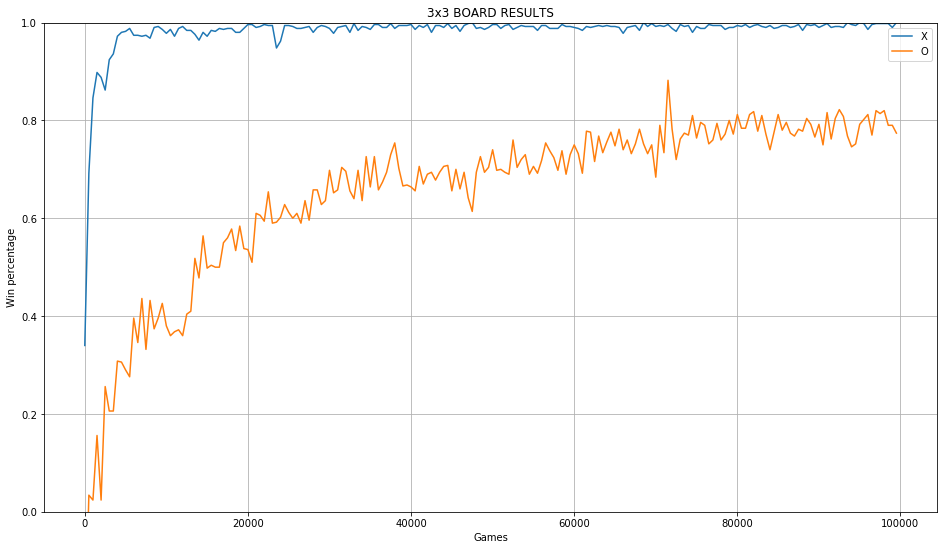

In [91]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()

agent1 = QStrategy(env.getState()[0], alpha=0.01, epsilon=0.4)
agent2 = QStrategy(env.getState()[0], alpha=0.01, epsilon=0.4)
    
steps, history_X, history_O = Q_training(env, agent1, agent2, episodes=100_000, eval_step=500)

plt.figure(figsize=(16,9))
plt.plot(steps, history_X, label='X')
plt.plot(steps, history_O, label='O')
plt.xlabel("Games")
plt.ylabel("Win percentage")
plt.title("3x3 BOARD RESULTS")
plt.grid()
plt.legend()
plt.ylim((0,1.0))
plt.show()


## 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

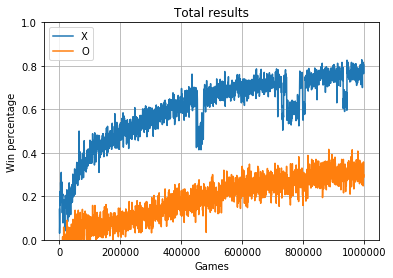

In [99]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()

agent1 = QStrategy(env.getState()[0], alpha=0.01, epsilon=0.4)
agent2 = QStrategy(env.getState()[0], alpha=0.01, epsilon=0.4)
    
steps, history_X, history_O = Q_training(env, agent1, agent2, episodes=1_000_000, eval_step=500)

plt.plot(steps, history_X, label='X')
plt.plot(steps, history_O, label='O')
plt.xlabel("Games")
plt.ylabel("Win percentage")
plt.title("Total results")
plt.grid()
plt.legend()
plt.ylim((0,1.0))
plt.show()

**Выводы:**
1. Очевидно, играть крестиками проще, чем ноликами.В теории на поле 3х3 наилучший результат (плато на графике) также может достигнуть более высокого значения - выигрывать или сводить к ничьей можно всегда, если рандом первым ходом не занял центральную клетку, но даже в таком случае шансы остаются
2. При увеличении поля сложность задачи растет (степенная сложность?) так сильно, что для больших полей учить модель оч долго. Но в теории опять же получить результаты против рандомной стратегии можно даже лучше, чем в поле 3х3 - случайным образом наставить 4 в ряд сложнее, чем делать это целенаправленно
3. В целом, модели учатся, но поле 5х5 не стал пробовать :)

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

## 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [152]:

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, extuple):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = extuple
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [153]:
class DQN_3_3(nn.Module):

    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hidden_size, kernel_size=(3,3)) # add stride?
#         self.bn1 = nn.BatchNorm2d(hidden_size)
#         self.conv2 = nn.Conv2d(hidden_size, 2 * hidden_size, kernel_size=3)
#         self.bn2 = nn.BatchNorm2d(2 * hidden_size)
#         self.conv3 = nn.Conv2d(2 * hidden_size, 2 * hidden_size, kernel_size=3)
#         self.bn3 = nn.BatchNorm2d(2 * hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.head = nn.Linear(hidden_size, 9) # 2 * hidden

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x)).squeeze(-1).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.head(x)
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
        return x

class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [154]:
# Utils
def state_to_layers(state):
    return np.array([
        (state == 1).astype(float), 
        (state == -1).astype(float), 
        (state == 0).astype(float)
    ])
        
def get_action_from_model(model, state):
    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()
    return action

def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    
def get_action(model, state, game_hash, epsilon):
    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))
    return action


In [155]:
class DQN_satrategy:
    def __init__(self, model, optimizer, memory_capacity=10000, epsilon=0.5, gamma=1.0):
        self.epsilon = epsilon
        self.gamma = gamma
        
        self.state = None
        self.action = None
        self.memory = ReplayMemory(capacity=memory_capacity)
        
        self.model = model
        self.optimizer = optimizer
    
    def update(self, next_state, action, reward):
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.push((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def reset_state(self):
        self.state = None
        self.action = None


In [156]:
# Testing

def testing_episode(env, model, player1_random=False, player2_random=False):
    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1
    
    while not done:
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)
        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        player = player * -1
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        
def testing(env, model, games=1000, player1_random=False, player2_random=False):
    model.eval()
    rewards1 = []
    rewards2 = []
    for i in range(games):
        reward1, reward2 = testing_episode(
            env, 
            model, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    return r1, r2

In [169]:
# Training

def train_batch(agent, criterion, batch_size=128):
    model = agent.model
    optimizer = agent.optimizer
    gamma = agent.gamma
    replay_memory = agent.memory
    
    if len(replay_memory) < batch_size:
#         print('memory')
        return
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss


def train_episode(env, agent1, agent2):
    env.reset()
    
    model1 = agent1.model
    model2 = agent2.model
    
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    board = env.board.copy()
    done = False
    
    agent1.reset_state()
    agent2.reset_state()
    agents = (agent1, agent2)
    models = (model1, model2)
    current_idx = 0
    
    while not done:
        cur_agent = agents[current_idx]
        model = models[current_idx]
        action = get_action(model, board, game_hash, cur_agent.epsilon)
        cur_agent.update(board, action, 0)
        current_idx = 1 - current_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        board = env.board.copy()
        
    if reward == -10:
        cur_agent.update(board, action, reward)
    else:
        agents[0].update(board, action, reward)
        agents[1].update(board, action, -reward)
        

def training(env, agent1, agent2, criterion, episodes=10000, batch_size=128, eval_step=100):
    history_X = []
    history_O = []
    steps = []

    for i in tqdm(range(episodes)):
        train_episode(env, agent1, agent2)
        
        train_batch(agent1, criterion, batch_size)
        train_batch(agent2, criterion, batch_size)

        if i % eval_step == 0:
            res1, _ = testing(env, agent1.model, games=200, player1_random=False, player2_random=True)
            _, res2 = testing(env, agent2.model, games=200, player1_random=True, player2_random=False)
            
            steps.append(i)
            history_X.append(res1)
            history_O.append(res2)
            
    return steps, history_X, history_O

In [173]:
LR = 1e-6
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr=LR)
agent1 = DQN_satrategy(model1, optimizer1, epsilon=0.5)

model2 = DQN_3x3(hidden_size=HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr=LR)
agent2 = DQN_satrategy(model2, optimizer1, epsilon=0.5)

In [174]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
steps, result_X, result_O = training(
    env, 
    agent1, 
    agent2, 
    criterion,
    episodes=5000, 
    batch_size=256,
)

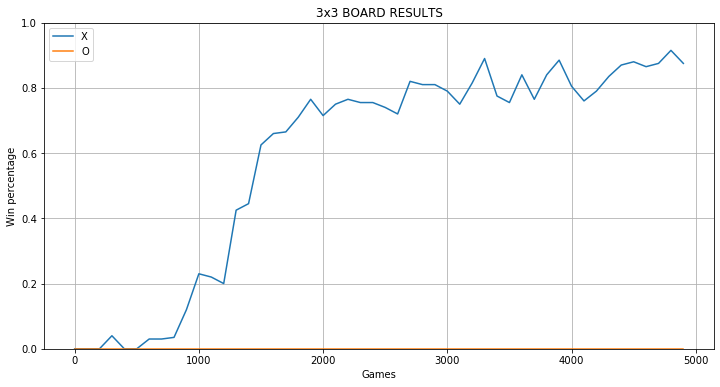

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(steps, result_X, label='X')
plt.plot(steps, result_O, label='O')
plt.xlabel("Games")
plt.ylabel("Win percentage")
plt.title("3x3 BOARD RESULTS")
plt.grid(True)
plt.legend()
plt.ylim((0,1.0))
plt.show()